In [1]:
# _*_ coding: utf-8 _*_

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

# remove warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
color = sns.color_palette()
%matplotlib inline
matplotlib.style.use('ggplot')

import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt

gray_color = '#778899'

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from get_datasets import load_train_test
from utils import xgb_utils

# my module
from conf.configure import Configure
from utils import dataframe_util, data_utils

In [2]:
train = pd.read_csv(Configure.base_path + 'sun_qian_guo/train.csv', encoding='utf8')
test = pd.read_csv(Configure.base_path + 'sun_qian_guo/test.csv', encoding='utf8')

In [3]:
train.head()

,userid,男,女,北京,浙江,甘肃,安徽,贵州,吉林,四川,...,rangePer7,rangePer8,rangePer9,rangePer10,rangePer11,rangeNum9,dateLow,dateHigh,dateContinue,dateCut
0,100000000013,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
1,100000000111,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
2,100000000127,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0
3,100000000231,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
4,100000000379,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1


In [4]:
test.head()

,userid,useridUse,男,女,北京,浙江,甘肃,安徽,贵州,吉林,...,rangePer7,rangePer8,rangePer9,rangePer10,rangePer11,rangeNum9,dateLow,dateHigh,dateContinue,dateCut
0,100000000371,100000000371,0,0,0,0,0,0,0,0,...,0.133333,0.0,0.066667,0.066667,0.0,1,0,0,0,1
1,100000001215,100000001215,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.0,0,0,0,1,0
2,100000001445,100000001445,1,0,0,1,0,0,0,0,...,0.000000,0.0,0.071429,0.071429,0.0,1,0,0,1,0
3,100000001575,100000001575,0,1,0,0,0,0,0,0,...,0.000000,0.0,0.066667,0.066667,0.0,2,0,1,0,0
4,100000001601,100000001601,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.0,0,0,0,1,0


In [9]:
for f in train.columns.values.tolist():
    print f.encode('utf8')

userid
useridUse
男
女
北京
浙江
甘肃
安徽
贵州
吉林
四川
江苏
福建
新疆
上海
海南
天津
重庆
云南
青海
内蒙古
湖北
河北
西藏
黑龙江
河南
广西
陕西
山东
广东
湖南
山西
江西
辽宁
宁夏
60后
70后
80后
90后
00后
['商品零售价格指数(上年同月=100)_2017年11月'
 '国内生产总值(亿元)_2015年'
 '国内生产总值(亿元)_2014年'
 '年末总人口(万人)_2015年'
 '年末总人口(万人)_2014年'
 '工业生产者出厂价格指数(上年同月=100)_2017年11月'
 '居民消费价格指数(上年同月=100)_2017年11月'
 '社会商品零售总额(亿元)_2015年'
 '社会商品零售总额(亿元)_2014年']
ageNum
simpleNum
continentPer
finalGoCity_东京
finalGoCity_京都
finalGoCity_伦敦
finalGoCity_兰卡威
finalGoCity_凯恩斯
finalGoCity_北海道--札幌
finalGoCity_华盛顿
finalGoCity_台中
finalGoCity_台北
finalGoCity_吉隆坡
finalGoCity_名古屋
finalGoCity_墨尔本
finalGoCity_夏威夷欧胡岛（檀香山）
finalGoCity_多伦多
finalGoCity_大阪
finalGoCity_奥克兰
finalGoCity_奥兰多
finalGoCity_尼斯
finalGoCity_巴厘岛
finalGoCity_巴塞罗那
finalGoCity_巴黎
finalGoCity_布里斯班
finalGoCity_悉尼
finalGoCity_拉斯维加斯
finalGoCity_新加坡
finalGoCity_旧金山
finalGoCity_普吉岛
finalGoCity_曼谷
finalGoCity_槟城
finalGoCity_沙巴--亚庇
finalGoCity_波士顿
finalGoCity_洛杉矶
finalGoCity_济州岛
finalGoCity_清迈
finalGoCity_温哥华
finalGoCity_米兰
finalGoCity_纽约
finalGoCity_罗马
fin

In [21]:
def evaluate_score(predict, y_true):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, predict, pos_label=1)
    auc_score = auc(false_positive_rate, true_positive_rate)
    return auc_score

In [6]:
print("load train test datasets")
train, test = load_train_test()

y_train_all = train['orderType']
id_test = test['userid']
del train['orderType']

df_columns = train.columns.values
print('===> feature count: {}'.format(len(df_columns)))
# print('feature check before modeling...')
# feature_util.feature_check_before_modeling(train, test, df_columns)

# scale_pos_weight = (np.sum(y_train_all == 0) / np.sum(y_train_all == 1)) - 1
scale_pos_weight = 1
print('scale_pos_weight = ', scale_pos_weight)

xgb_params = {
    'eta': 0.01,
    'min_child_weight': 20,
    'colsample_bytree': 0.5,
    'max_depth': 15,
    'subsample': 0.9,
    'lambda': 2.0,
    'scale_pos_weight': scale_pos_weight,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'updater': 'grow_gpu',
    'gpu_id': 2,
    'nthread': -1,
    'silent': 1,
    'booster': 'gbtree'
}

X_train, X_valid, y_train, y_valid = train_test_split(train, y_train_all, test_size=0.25, random_state=42)
print('train: {}, valid: {}, test: {}'.format(X_train.shape[0], X_valid.shape[0], test.shape[0]))

dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
dvalid = xgb.DMatrix(X_valid, y_valid, feature_names=df_columns)
dtest = xgb.DMatrix(test, feature_names=df_columns)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

load train test datasets
pd merge action_history_features5
pd merge action_history_features4
pd merge action_history_features6
pd merge action_history_features3
pd merge action_history_features2
pd merge basic_user_info
pd merge user_order_comment_features
pd merge action_history_features9
pd merge action_history_features8
pd merge wxr_features
pd merge user_order_history_features
pd merge user_order_history_features4
pd merge user_order_history_features3
pd merge user_order_history_features2
pd merge basic_user_action_features
pd merge action_history_features
pd merge action_history_features11
pd merge action_history_features10
特征组合
一些类别特征进行 one-hot
特征组合
连续特征离散化
===> feature count: 413
('scale_pos_weight = ', 1)
train: 30230, valid: 10077, test: 10076


In [7]:
y_train_all

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       1
11       1
12       0
13       0
14       1
15       0
16       1
17       1
18       0
19       0
20       0
21       0
22       1
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
40277    1
40278    1
40279    0
40280    0
40281    0
40282    0
40283    1
40284    0
40285    0
40286    0
40287    0
40288    0
40289    0
40290    0
40291    1
40292    1
40293    0
40294    0
40295    0
40296    0
40297    0
40298    0
40299    0
40300    0
40301    0
40302    1
40303    0
40304    0
40305    0
40306    0
Name: orderType, Length: 40307, dtype: int64

In [4]:
model = xgb.train(dict(xgb_params),
                      dtrain,
                      evals=watchlist,
                      verbose_eval=50,
                      early_stopping_rounds=100,
                      num_boost_round=4000)

[0]	train-auc:0.906948	valid-auc:0.879324
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[50]	train-auc:0.964472	valid-auc:0.945064
[100]	train-auc:0.969203	valid-auc:0.948659
[150]	train-auc:0.972061	valid-auc:0.95024
[200]	train-auc:0.974725	valid-auc:0.952078
[250]	train-auc:0.977075	valid-auc:0.953679
[300]	train-auc:0.979208	valid-auc:0.955077
[350]	train-auc:0.981044	valid-auc:0.956324
[400]	train-auc:0.982665	valid-auc:0.95735
[450]	train-auc:0.984166	valid-auc:0.958426
[500]	train-auc:0.985522	valid-auc:0.959296
[550]	train-auc:0.986735	valid-auc:0.960063
[600]	train-auc:0.987817	valid-auc:0.960662
[650]	train-auc:0.988822	valid-auc:0.961174
[700]	train-auc:0.989689	valid-auc:0.9616
[750]	train-auc:0.990475	valid-auc:0.961991
[800]	train-auc:0.991184	valid-auc:0.962342
[850]	train-auc:0.991851	valid-auc:0.962578
[900]	train-auc:0.992444	valid-auc:0.962713
[950]	train-auc:0.993004	va

In [5]:
# predict train
predict_train = model.predict(dtrain)
train_auc = evaluate_score(predict_train, y_train)

# predict validate
predict_valid = model.predict(dvalid)
valid_auc = evaluate_score(predict_valid, y_valid)

print('train auc = {:.7f} , valid auc = {:.7f}\n'.format(train_auc, valid_auc))

train auc = 0.9983051 , valid auc = 0.9637881



In [6]:
fpr, tpr, _ = roc_curve(y_valid, predict_valid)
roc_auc = auc(fpr, tpr)

In [7]:
print fpr.shape, tpr.shape
print roc_auc

(983,) (983,)
0.963788125318


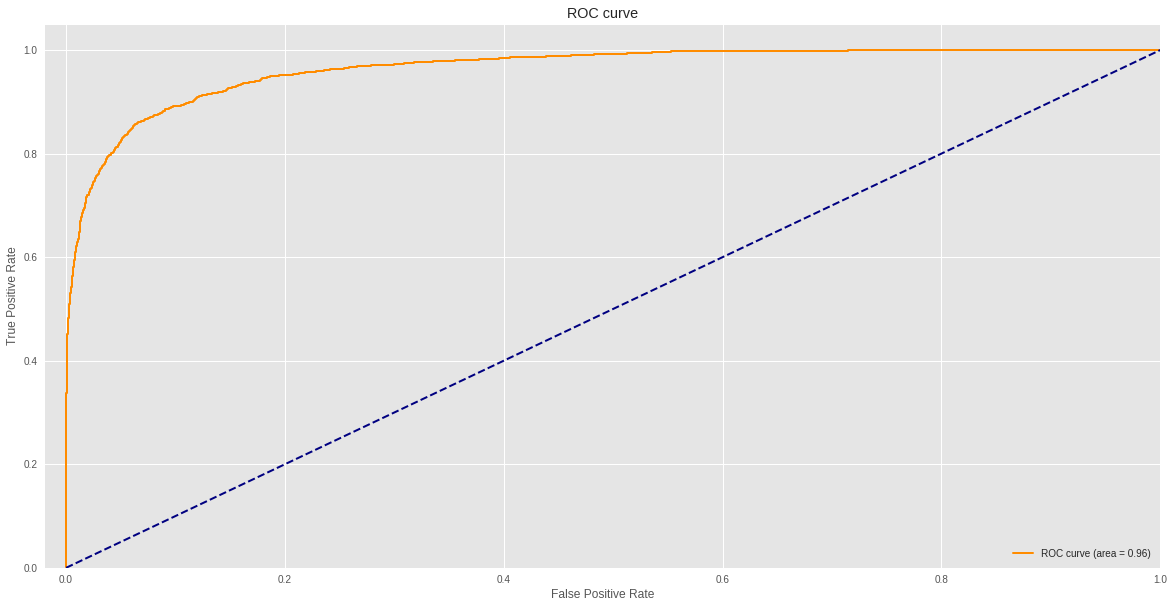

In [8]:
plt.figure(figsize=(20,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [25]:
print('---> cv train to choose best_num_boost_round')
dtrain_all = xgb.DMatrix(train.values, y_train_all, feature_names=df_columns)

cv_result = xgb.cv(dict(xgb_params),
                   dtrain_all,
                   num_boost_round=4000,
                   early_stopping_rounds=100,
                   verbose_eval=100,
                   show_stdv=False,
                   )
best_num_boost_rounds = len(cv_result)
mean_train_logloss = cv_result.loc[best_num_boost_rounds-11 : best_num_boost_rounds-1, 'train-auc-mean'].mean()
mean_test_logloss = cv_result.loc[best_num_boost_rounds-11 : best_num_boost_rounds-1, 'test-auc-mean'].mean()
print('best_num_boost_rounds = {}'.format(best_num_boost_rounds))

# num_boost_round = int(best_num_boost_rounds * 1.1)
# print('num_boost_round = ', num_boost_round)

print('mean_train_auc = {:.7f} , mean_test_auc = {:.7f}\n'.format(mean_train_logloss, mean_test_logloss))

---> cv train to choose best_num_boost_round
[0]	train-auc:0.902163	test-auc:0.877893


KeyboardInterrupt: 

In [ ]:
print('---> training on total dataset to predict test and submit')
model = xgb.train(dict(xgb_params),
                  dtrain_all,
                  num_boost_round=best_num_boost_rounds)
print('---> predict and submit')
print('---> predict submit')
y_pred = model.predict(dtest)
df_sub = pd.DataFrame({'userid': id_test, 'orderType': y_pred})

In [ ]:
df_sub = df_sub.sort_values(by='orderType', ascending=False)

In [ ]:
plt.figure(figsize=(20,10))
sns.distplot(df_sub[df_sub['orderType'] > 0.5]['orderType'], bins=1000)
plt.show()

In [ ]:
df_sub.head(100)

In [ ]:
orderHistory_test = pd.read_csv(Configure.cleaned_path + 'cleaned_orderHistory_test.csv',encoding='utf8')

In [ ]:
len(set(orderHistory_test['userid']).intersection(set(df_sub[df_sub['orderType'] > 0.999]['userid'])))

In [ ]:
orderHistory_test[orderHistory_test['userid'] == 114832153545]

In [19]:
test_one_index = test[test['2016_2017_first_last_ordertype'] == 1].index
test_one = test.loc[test_one_index, :]
test_one['orderType'] = 1
train = pd.concat([train, test_one])